# RCP Simulations


## 1. Loading Dataset & Model

Here we perform some simulation using the Representative Concentration Pathways (RCP) datasets, which include emissions _projections_ (not emissions) which assume variouse mitigating factors for all major anthropogenic greenhouse gases from $1765$ to $2500$. We only consider CO2 emissions for fossil, industrial, and land use-related emissions in the $4$ RCP scenario and its mean. We refer the reader to Meinshausen et al., [The RCP greenhouse gas concentrations and their extensions from 1765 to 2300](https://link.springer.com/article/10.1007/s10584-011-0156-z) for further details. See `data/source/EmiAndConcData` for the full source dataset and `data/emissions` for the cleaned-up snippet of the dataset that is used for our experiment only.

We load the calibrated model, which has been trained in `\solver` and saved in `\results`. The model equilibrium masses, $\mathbf{m}^{eq}$, have been calibrated to the pre-industrial year which assume to correspond to RCP dataset starting year of $1765$


In [201]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import copy

import __lib_operations as operations
import lib_data_load as data_load
from lib_models import model_3sr,model_4pr

_plot_vis = {}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['style']  = ['solid','dashed','dotted','dashdot']
_plot_vis['marker'] = ['o','v','s','D','X']

make_plot = lambda n,m: plt.subplots(n,m,figsize=(m*4,n*3),squeeze=False,layout='tight')

# shortcut for finding index of given value
inx_find = lambda x, val: int(np.where(x == val)[0])

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True

# Load data


In [202]:
_root               = 'result_update/free/T-250/'
_test_name_base     = 'MMM-0.0_0.0_0.0'
_test_name_base_sel = 'MMM-0.0_0.0001_0.0001'
_test_name_sel      = 'MMM-0.01_0.0001_0.0001'

_alpha_data = {'3SR': np.array([0.48588089, 2.4139541 ]), '4PR': np.array([0.48309684, 2.44476024])}


_model_set = [model_3sr,model_4pr]

Text(0.5, 0, 'Year')

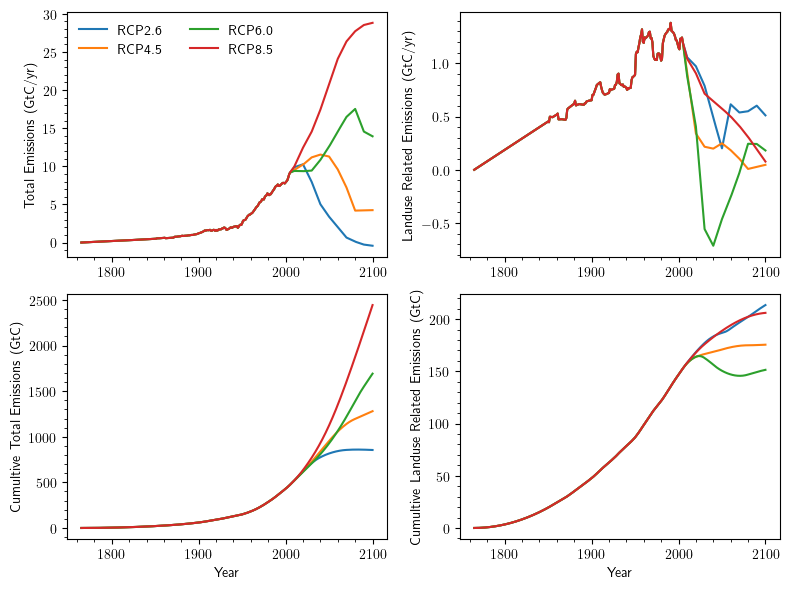

In [203]:
fig, axs = make_plot(2,2)
for i, scenerio in enumerate(['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']):
    
    [data_val,data_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=1765,T_end=2100,emission_type='fossil+land')
    axs[0,0].plot(data_year,data_val,label=scenerio)
    axs[1,0].plot(data_year,np.cumsum(data_val),label=scenerio)
    
    [data_val,data_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=1765,T_end=2100,emission_type='land')
    axs[0,1].plot(data_year,data_val,label=scenerio)
    axs[1,1].plot(data_year,np.cumsum(data_val),label=scenerio)
    
axs[0,0].minorticks_on()
axs[0,1].minorticks_on() 
axs[1,0].minorticks_on() 
axs[1,1].minorticks_on() 

axs[0,0].legend(frameon=False,loc='upper left',ncol=2)

axs[0,0].set_ylabel(r'Total Emissions (GtC/yr)')
axs[0,1].set_ylabel(r'Landuse Related Emissions (GtC/yr)')

axs[1,0].set_ylabel(r'Cumultive Total Emissions (GtC)')
axs[1,1].set_ylabel(r'Cumultive Landuse Related Emissions (GtC)')
                                           
axs[1,0].set_xlabel(r'Year')    
axs[1,1].set_xlabel(r'Year')  

# integrate to current conditions for Econ Model


In [204]:

#Load model results
_results          = operations.load_results(root=_root,test_name=_test_name_sel,model_set=_model_set)
_results['4PR-X'] = copy.copy(_results['4PR'])

# start simulation at 1765
[emis_val,emis_year]    = data_load.cmip_emission(scenerio_name='RCP8.5',T_start=1765,T_end=2100,emission_type='fossil+land')
[emis_val_l,emis_year ] = data_load.cmip_emission(scenerio_name='RCP8.5',T_start=1765,T_end=2100,emission_type='land')

m_at_current = 2.12*421

for model_inx,model_name in enumerate(_results.keys()): 

    model = _results[model_name]['model'] 
    info= model()

    A    = _results[model_name]['A']
    m_eq = _results[model_name]['m_eq']
                
    m_sim = []
    m_sim.append(m_eq)
                    
    e = np.zeros(len(m_eq))
                
    t = 0
    while m_sim[-1][0]< m_at_current:

        if 'X' in model_name:
            e[0]  = emis_val[t]
            e[-1] = -emis_val_l[t]
        else:
            e[0]=emis_val[t]

        m_sim+=[ A@m_sim[-1] +m_sim[-1] +  e ]

        e = e * 0.0

        t+=1

    m_sim=np.array(m_sim).T

    _results[model_name]['m_ini']         =  np.round(m_sim[:,-1] ,1)  
    _results[model_name]['t_current']     =  1765+t   
    _results[model_name]['t_current_inx'] = t
    
operations.tabulate(results=_results,vars=['m_ini','t_current','t_current_inx'])

import pickle
import copy

results_dump = copy.deepcopy(_results)

for model_inx,model_name in enumerate(results_dump.keys()):  
    results_dump[model_name]['model'] = None

# open a file, where you ant to store the data
file = open('test/data_dump.pkl', 'wb')

# dump information to that file
pickle.dump(results_dump, file)

# close the file
file.close()

+-----------------------------------------------------------------------------------------------------------------+
|                                                      Table                                                      |
+-------+----------------+------------------------+-----------------------------------+-----------+---------------+
| model | benchmark_name |          rho           |               m_ini               | t_current | t_current_inx |
+-------+----------------+------------------------+-----------------------------------+-----------+---------------+
|  3SR  |      MMM       | [0.01   0.0001 0.0001] |       [ 897.1 1020.8 1399. ]      |    2025   |      260      |
|  4PR  |      MMM       | [0.01   0.0001 0.0001] | [  896.8  1267.1 37298.4   553.4] |    2025   |      260      |
| 4PR-X |      MMM       | [0.01   0.0001 0.0001] | [  893.3  1244.6 37291.2   538. ] |    2034   |      269      |
+-------+----------------+------------------------+---------------------

# RCP Emission $\to$ Concentrations $\to$ Temprature


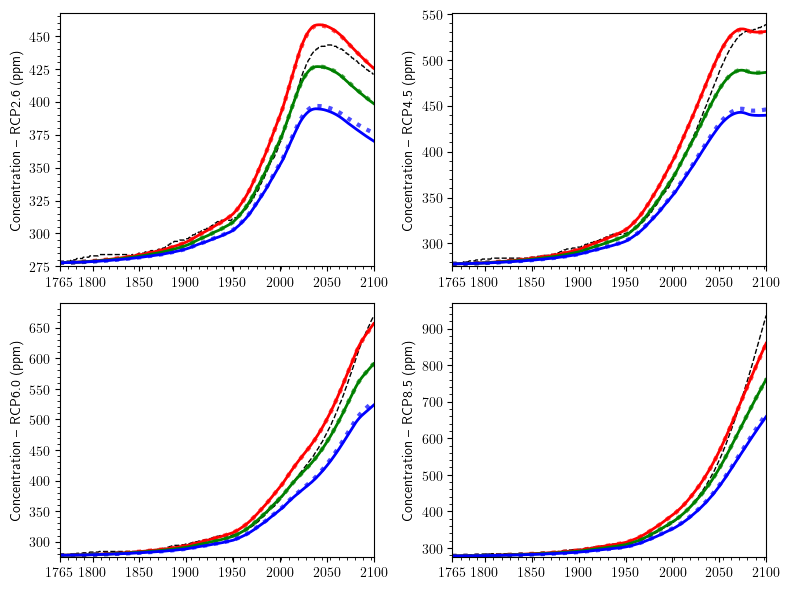

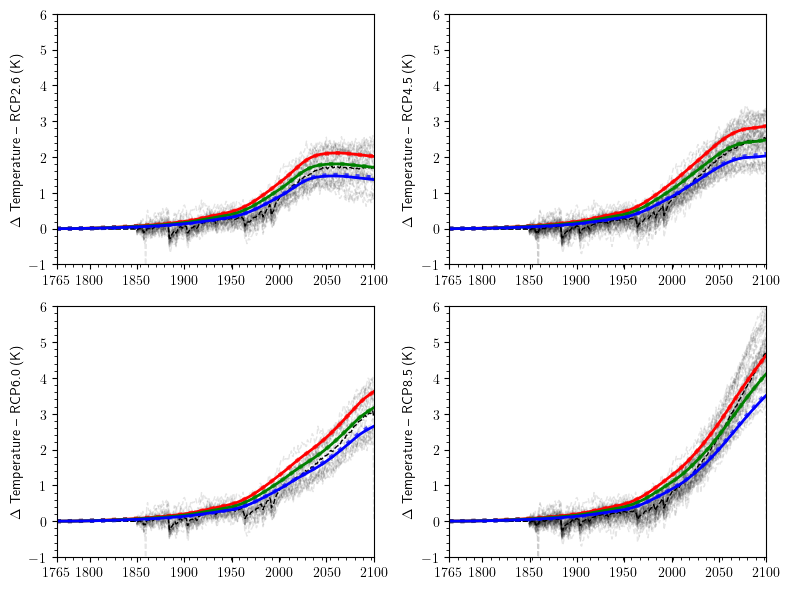

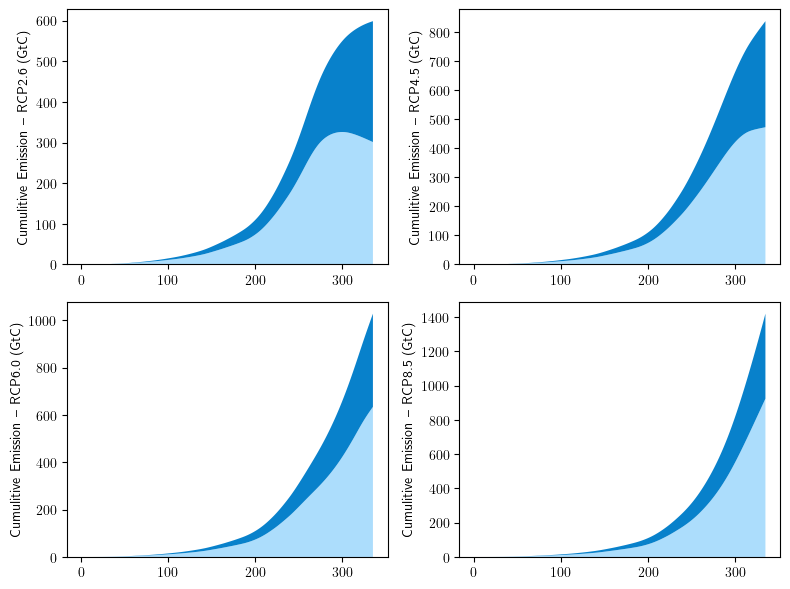

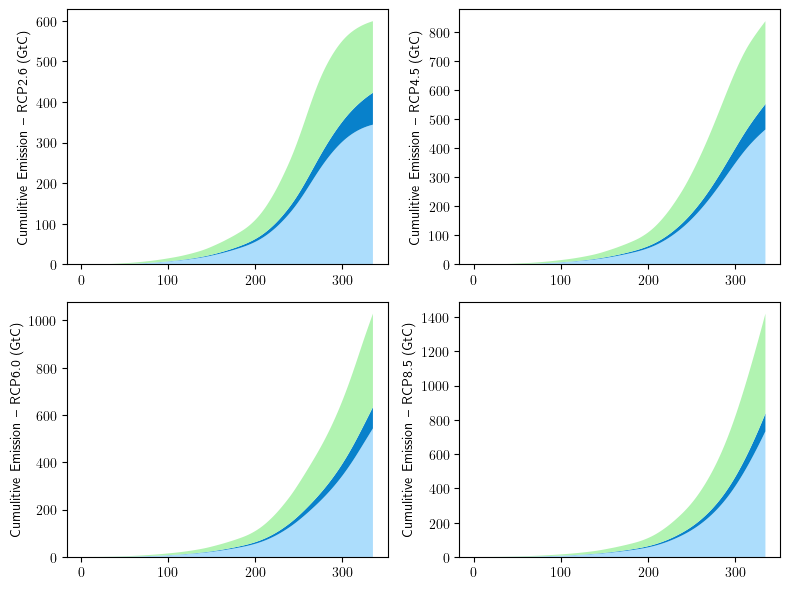

In [205]:
def plot_rcp_conc_temp(test_name_set,root=_root,alpha_data=_alpha_data):

    T_start = 1765
    T_end   = 2100
    T = T_end-T_start +1
 
    color_set = [(0.6743529411764707, 0.8670274509803922, 0.9864313725490196), (0.03321568627450988, 0.5048784313725492, 0.7971764705882353),
                (0.6946139705882354, 0.9532291666666667, 0.6946139705882354), (0.10942708333333329, 0.7144944852941177, 0.10942708333333329)]
      

    scenerio_set       = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    fig_conc, axs_conc = make_plot(2,2)
    fig_temp, axs_temp = make_plot(2,2)
    fig_comp_3sr, axs_comp_3sr = make_plot(2,2)
    fig_comp_4pr, axs_comp_4pr = make_plot(2,2)


    calib_data_3sr = operations.load_results(root=root,test_name=test_name_set[0] ,T_sim_set=[10,100,500,1000])['3SR']
    calib_data_4pr = operations.load_results(root=root,test_name=test_name_set[1] ,T_sim_set=[10,100,500,1000])['4PR']

    for i in range(2):
        for j in range(2):
            scenerio = scenerio_set[i*2+j]

            [emis_val     ,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='fossil+land')  
            [emis_land_val,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='land')    
            [conc_val     ,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio  ,T_start=T_start,T_end=T_end)
            [temp_val     ,temp_year] = data_load.cmip_temperature(  scenerio_name=scenerio  ,T_start=T_start,T_end=T_end)

            temp_val = (temp_val.T - temp_val[:,0]).T
            
            axs_conc[i,j].plot(conc_year,conc_val,linewidth=1,alpha=1,color='black',linestyle='--',label='Mean Concentration')
            axs_temp[i,j].plot(temp_year,np.mean(temp_val,0),linewidth=1,alpha=1,color='black',linestyle='--',label='Mean Temperature')
            axs_temp[i,j].plot(temp_year,temp_val.T,linewidth=1,alpha=.1,color='black',linestyle='--',label='Mean Temperature')

            ###########
            # 3SR Model
            ###########
            A      = calib_data_3sr['A']
            m_eq   = np.array(calib_data_3sr['m_eq'],dtype='f')
            e      = np.zeros(shape=(A.shape[0],len(emis_val)))
            e[0,:] = emis_val[0:T]

            [m_sim,temp_at,temp_o]  = operations.simulate(A=A*alpha_data['3SR'][0],m0=m_eq,T=len(emis_val),e=e)
            m_sim_3sr_1   = m_sim
            temp_at_3sr_1 = temp_at

            [m_sim,temp_at,temp_o]  = operations.simulate(A=A,m0=m_eq,T=len(emis_val),e=e)
 
            m_sim_3sr_2   = m_sim
            temp_at_3sr_2 = temp_at

            [m_sim,temp_at,temp_o]  = operations.simulate(A=A*alpha_data['3SR'][1],m0=m_eq,T=len(emis_val),e=e)
            m_sim_3sr_3   = m_sim
            temp_at_3sr_3 = temp_at

            axs_conc[i,j].plot(emis_year,m_sim_3sr_1[0,:]/2.12, linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='red',linestyle='dotted')
            axs_temp[i,j].plot(temp_year,temp_at_3sr_1        , linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='red',linestyle='dotted')

            axs_conc[i,j].plot(emis_year,m_sim_3sr_2[0,:]/2.12, linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='green',linestyle='dotted')
            axs_temp[i,j].plot(temp_year,temp_at_3sr_2        , linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='green',linestyle='dotted')

            axs_conc[i,j].plot(emis_year,m_sim_3sr_3[0,:]/2.12, linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='blue',linestyle='dotted')
            axs_temp[i,j].plot(temp_year,temp_at_3sr_3        , linewidth=3,alpha=.7, label=r'3SR,$\mu$',color='blue',linestyle='dotted')

            D = copy.copy(m_sim_3sr_2)

            for ii in range(0,D.shape[0]):
                D[ii,:]=D[ii,:]-m_eq[ii]

            axs_comp_3sr[i,j].stackplot(range(0, len(emis_val)),D[1:A.shape[0],:], colors=color_set[0:A.shape[0]])



            ###########
            # 4PR Model
            ###########
            A      = calib_data_4pr['A']
            m_eq   = np.array(calib_data_4pr['m_eq'],dtype='f')
            e      = np.zeros(shape=(A.shape[0],len(emis_val)))
            e[0,:] = emis_val[0:T]

            if True:
                [m_sim_4pr_1,temp_at_4pr_1,_]  = operations.simulate(A=A*alpha_data['4PR'][0],m0=m_eq,T=len(emis_val),e=e)
                [m_sim_4pr_2,temp_at_4pr_2,_] = operations.simulate(A=A,m0=m_eq,T=len(emis_val),e=e)
                [m_sim_4pr_3,temp_at_4pr_3,_] = operations.simulate(A=A*alpha_data['4PR'][1],m0=m_eq,T=len(emis_val),e=e)
            else: 
                model       = calib_data_4pr['model']
                a           = calib_data_4pr['a']
                m_eq_update = np.copy(calib_data_4pr['m_eq'])
                A_set       = []
                
                for t,emis_land_val_t in enumerate(emis_land_val):
                    m_eq_update[-1] -= emis_land_val[t]
                    [A,_,_  ] = model(a,m_eq_update)
                    A_set.append(np.copy(A))

                A_set_u  = []
                A_set_d  = []

                for A in A_set:
                    A_set_d.append(np.copy(A)*alpha_data['4PR'][0])
                    A_set_u.append(np.copy(A)*alpha_data['4PR'][1])

                [m_sim_4pr_1,temp_at_4pr_1,_]  = operations.simulate_dynamic(A_set=A_set_d,m0=m_eq,T=len(emis_val),e=e)
                [m_sim_4pr_2,temp_at_4pr_2,_]  = operations.simulate_dynamic(A_set=A_set,m0=m_eq,T=len(emis_val),e=e)
                [m_sim_4pr_3,temp_at_4pr_3,_]  = operations.simulate_dynamic(A_set=A_set_u,m0=m_eq,T=len(emis_val),e=e)

            axs_conc[i,j].plot(emis_year,(m_sim_4pr_1[0,:] )/2.12, linewidth=2,alpha=1, label=r'4PR,$\mu$',color='red',linestyle='solid') 
            axs_temp[i,j].plot(temp_year,temp_at_4pr_1,            linewidth=2,alpha=1, label=r'4PR,$\mu$',color='red',linestyle='solid')
            
            axs_conc[i,j].plot(emis_year,(m_sim_4pr_2[0,:])/2.12,  linewidth=2,alpha=1, label=r'4PR,$\mu$',color='green',linestyle='solid')
            axs_temp[i,j].plot(temp_year,temp_at_4pr_2,            linewidth=2,alpha=1, label=r'4PR,$\mu$',color='green',linestyle='solid')

            axs_conc[i,j].plot(emis_year,(m_sim_4pr_3[0,:])/2.12,  linewidth=2,alpha=1, label=r'4PR,$\mu$',color='blue',linestyle='solid')
            axs_temp[i,j].plot(temp_year,temp_at_4pr_3,            linewidth=2,alpha=1, label=r'4PR,$\mu$',color='blue',linestyle='solid')

            D = copy.copy(m_sim_4pr_2)

            for ii in range(0,D.shape[0]):
                D[ii,:]=D[ii,:]-m_eq[ii]

            axs_comp_4pr[i,j].stackplot(range(0, len(emis_val)),D[1:A.shape[0],:], colors=color_set[0:A.shape[0]])


            axs_conc[i,j].minorticks_on() 
            axs_temp[i,j].minorticks_on() 

            axs_conc[i,j].set_ylabel(r'Concentration -- '+scenerio+' (ppm)')
            axs_temp[i,j].set_ylabel(r'$\Delta$ Temperature -- '+scenerio+' (K)')
            axs_comp_3sr[i,j].set_ylabel(r'Cumulitive Emission -- '+scenerio+' (GtC)')
            axs_comp_4pr[i,j].set_ylabel(r'Cumulitive Emission -- '+scenerio+' (GtC)')


            axs_conc[i,j].set_ylim(bottom=275)
            axs_conc[i,j].set_xlim(left=T_start,right=T_end)
            axs_conc[i,j].set_xticks([1765,1800,1850,1900,1950,2000,2050,2100])

            axs_temp[i,j].set_ylim(bottom=-1,top=6)
            axs_temp[i,j].set_xlim(left=T_start,right=T_end)
            axs_temp[i,j].set_xticks([1765,1800,1850,1900,1950,2000,2050,2100])


plot_rcp_conc_temp(test_name_set=[_test_name_base,_test_name_sel])

Mc dog

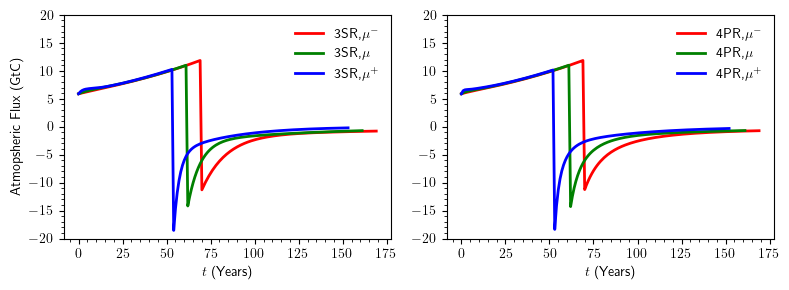

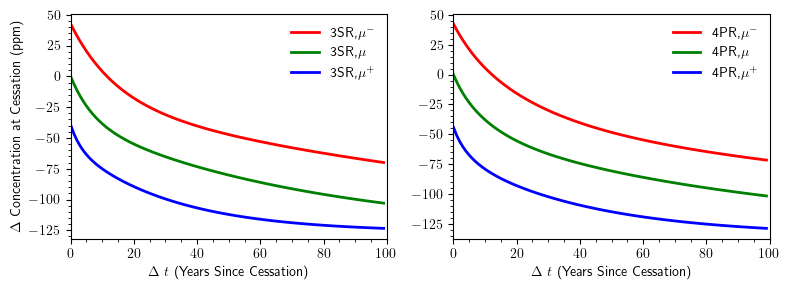

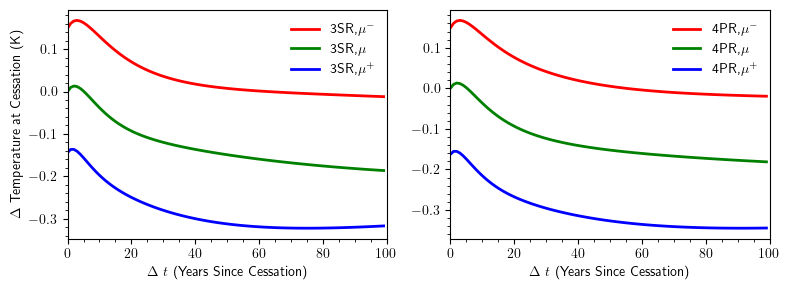

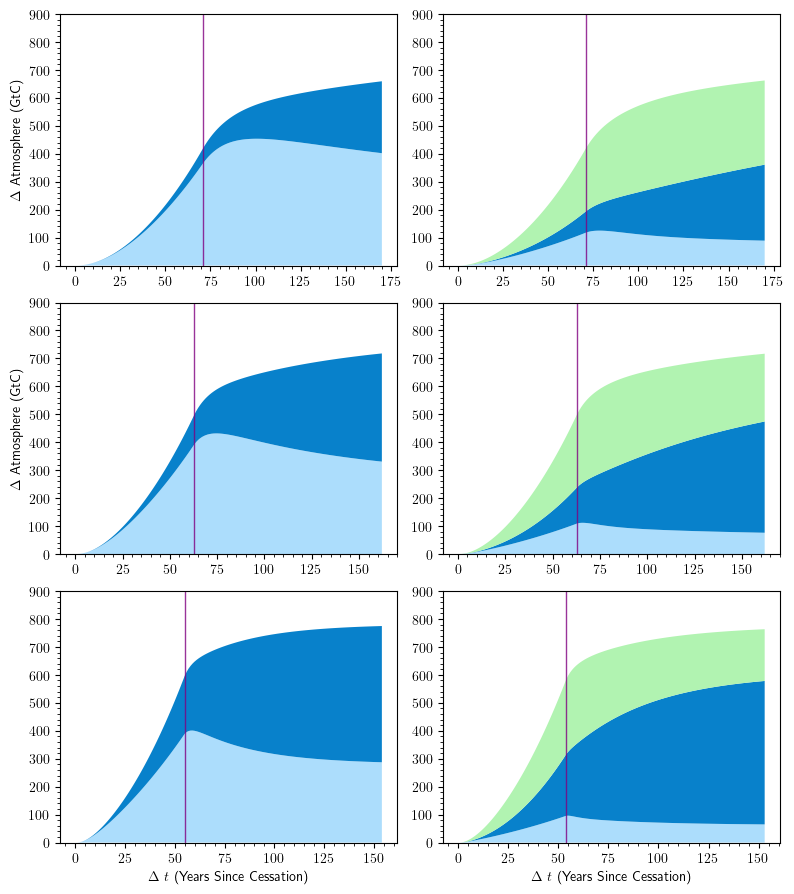

In [206]:
def plot_mcdoogle(test_name_set,root=_root, alpha_data=_alpha_data):

    global _alpha_data

    calib_data_3sr = operations.load_results(root=root,test_name=test_name_set[0] ,T_sim_set=[10,100,500,1000])
    calib_data_4pr = operations.load_results(root=root,test_name=test_name_set[1] ,T_sim_set=[10,100,500,1000])

    T_mac_dougall        = 100
    m_sim_set            = [0]*3
    temp_sim_set         = [0]*3
    T_stop_emissions_set = [0]*3

    ###############
    ## 3SR
    ###############
    T_stop_emissions_set_3sr = []
    m_sim_set_3sr            = []
    temp_at_sim_set_3sr      = []
    temp_o_sim_set_3sr       = []

    alpha_set = [ alpha_data['3SR'][0], 1 ,alpha_data['3SR'][1]]
    A_base    = calib_data_3sr['3SR']['A']
    m_eq      = calib_data_3sr['3SR']['m_eq']

    for i in range(3):

        A        = A_base*alpha_set[i]
        m_sim    = [m_eq]
        emis_val = [0]

        # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
        while np.sum(emis_val) < 1000*.99:

            # m_new = Am + m + e
            # 1.01  = m_new/m = (Am + m)/m + e/m = A+1+e/m
            # e/m   = (1.01 - (Am - m)/m) =  0.1 - A
            # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)

            m  = np.copy(m_sim[-1])
            Am = A@m

            # compute emissions to get 1% increase
            emis_val += [1.0/100.0 * m[0] - Am[0]]
            m[0]     += emis_val[-1]
            m_sim    += [Am + m]

        T_stop_emissions_set_3sr.append(len(emis_val))

        emis_val = emis_val + [0]*T_mac_dougall

        e = np.zeros(shape=(A.shape[0],len(emis_val)))
        e[0,:] = emis_val

        [m_sim,temp_at,temp_o] = operations.simulate(A=A, m0=m_eq, T=e.shape[1], e=e)

        m_sim_set_3sr.append(m_sim)
        temp_at_sim_set_3sr.append(temp_at)
        temp_o_sim_set_3sr.append(temp_o)

    ###############
    ## 4PR
    ###############
    T_stop_emissions_set_4pr = []
    m_sim_set_4pr            = []
    temp_at_sim_set_4pr      = []
    temp_o_sim_set_4pr       = []

    alpha_set = [ alpha_data['4PR'][0], 1 ,alpha_data['4PR'][1]]
    A_base    = calib_data_3sr['4PR']['A']
    m_eq      = calib_data_3sr['4PR']['m_eq']

    for i in range(3):

        A        = A_base*alpha_set[i]
        m_sim    = [m_eq]
        emis_val = [0]

        # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
        while np.sum(emis_val) < 1000*.99:

            # m_new = Am + m + e
            # 1.01  = m_new/m = (Am + m)/m + e/m
            # e/m   = (1.01 - (Am - m)/m)
            # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)
            m  = np.copy(m_sim[-1])
            Am = A@m

            # compute emissions to get 1% increase
            emis_val += [1.0/100.0 * m[0] - Am[0]]
            m[0]     += emis_val[-1]
            m_sim    += [Am + m]

        T_stop_emissions_set_4pr.append(len(emis_val))

        emis_val = emis_val + [0] * T_mac_dougall

        e = np.zeros(shape=(A.shape[0],len(emis_val)))
        e[0,:] = emis_val

        [m_sim,temp_at,temp_o] = operations.simulate(A=A, m0=m_eq, T=e.shape[1], e=e)

        m_sim_set_4pr.append(m_sim)
        temp_at_sim_set_4pr.append(temp_at)
        temp_o_sim_set_4pr.append(temp_o)

    T_stop_emissions_set = [T_stop_emissions_set_3sr,T_stop_emissions_set_4pr]
    m_sim_set            = [m_sim_set_3sr,m_sim_set_4pr]
    temp_at_sim_set      = [temp_at_sim_set_3sr,temp_at_sim_set_4pr]
    temp_o_sim_set       = [temp_o_sim_set_3sr,temp_o_sim_set_4pr]


    label_set = [['3SR,$\mu^{-}$','3SR,$\mu$','3SR,$\mu^{+}$'],['4PR,$\mu^{-}$','4PR,$\mu$','4PR,$\mu^{+}$']]
    test_type_style = [['$\mu^+$','red'],['$\mu$','green'],['$\mu^-$','blue']]
    color_set = [(0.6743529411764707, 0.8670274509803922, 0.9864313725490196), (0.03321568627450988, 0.5048784313725492, 0.7971764705882353),
                (0.6946139705882354, 0.9532291666666667, 0.6946139705882354), (0.10942708333333329, 0.7144944852941177, 0.10942708333333329)]
                 
    #######################
    # Plot Delta ATM
    #######################
    fig, axs = make_plot(1,2)
    for i in range(2):

        label_set_i = label_set[i]
        data_i = m_sim_set[i]


        for inx in range(0,len(test_type_style)):

            #inx = 0
            data = np.copy(data_i[inx])
            data = np.diff(data[0, :])
            axs[0, i].plot(data, linewidth=2, alpha=1,label=label_set_i[inx], color=test_type_style[inx][1])
            #axs[0, 0].axvline(x=T_stop_emissions_set_3sr[inx], color='red',alpha=0.8, linewidth=3)

        axs[0, i].set_xticks(np.arange(0, 200, 25))
        axs[0, i].set_ylim(-20, 20)
        axs[0, i].minorticks_on()
        axs[0, i].legend(frameon=False, loc='upper right', ncol=1)
        axs[0, i].set_xlabel(r'$t$ (Years)') 

    axs[0, 0].set_ylabel(r'Atmopsheric Flux (GtC)')
    fig.savefig('doc/fig/simulate_macdougall_1.png', dpi=300)

    #######################
    # Plot Concentration ATM
    #######################
    fig, axs = make_plot(1,2)
    for i in range(2):

        label_set_i = label_set[i]
        data_i = m_sim_set[i]


        for inx in range(0,len(test_type_style)):
        
            data = np.copy(data_i[inx])
            
            data = data[0,T_stop_emissions_set[i][inx]:] - data_i[1][0,T_stop_emissions_set[i][1]]

            data = data/2.12
            axs[0,i].plot(data, linewidth=2, alpha=1,label=label_set_i[inx], color=test_type_style[inx][1])

        #axs[0, 1].set_xticks(np.arange(0, 200, 25))
        #axs[0, 1].set_ylim(-15, 15)
        axs[0,i].set_xlim(0, 100)
        axs[0,i].minorticks_on()
        axs[0,i].legend(frameon=False, loc='upper right', ncol=1)
        axs[0,i].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 

    axs[0,0].set_ylabel(r'$\Delta$ Concentration at Cessation (ppm)')
    fig.savefig('doc/fig/simulate_macdougall_2.png', dpi=300)

    #######################
    # Plot Temp
    #######################
    fig, axs = make_plot(1,2)
    for i in range(0,len(label_set)):

        label_set_i = label_set[i]
        data_i = temp_at_sim_set[i]

        for inx in range(0,len(test_type_style)):
        
            data = np.copy(data_i[inx])
            
            data = data[T_stop_emissions_set[i][inx]:] -  data_i[1][T_stop_emissions_set[i][1]]

            data = data/2.12
            axs[0, i].plot(data, linewidth=2, alpha=1,label=label_set_i[inx], color=test_type_style[inx][1])

        #axs[0, 1].set_xticks(np.arange(0, 200, 25))
        #axs[0, 1].set_ylim(-15, 15)
        axs[0, i].set_xlim(0, 100)
        axs[0, i].minorticks_on()
        axs[0, i].legend(frameon=False, loc='upper right', ncol=1)
        axs[0, i].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 

    axs[0, 0].set_ylabel(r'$\Delta$ Temperature at Cessation (K)')
    fig.savefig('doc/fig/simulate_macdougall_3.png', dpi=300)

    fig, axs = make_plot(3,2)
    for i in range(0,len(label_set)):
        label_set_i = label_set[i]
        for inx in range(0,len(test_type_style)):
            data = np.copy(m_sim_set[i][inx])
            p, T = data.shape

            for j in range(0, p):
                data[j, :] = data[j, :] - m_sim_set[i][inx][j, 0]

            axs[inx,i].stackplot(range(0, T),data[1:p,:], colors=color_set[0:p])
            #axs[i, inx].plot(data[0,:])
            axs[inx,i].axvline(x=T_stop_emissions_set[i][inx], color='purple',alpha=0.8, linewidth=1)
            axs[inx,i].set_ylim(0, 900)
            axs[inx,i].minorticks_on()
            
        axs[i,0].set_ylabel(r'$\Delta$ Atmosphere (GtC)')


    axs[-1,0].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 
    axs[-1,1].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 

    fig.savefig('doc/fig/simulate_macdougall_4.png', dpi=300)
  
plot_mcdoogle(test_name_set=[_test_name_base,_test_name_sel])

In [207]:
import lib_data_load as data_load


d = data_load.land_emission()

print(d)

a =d['Flasc']

print(a)
print(d['year'][:])

#for i in range(11):
    #plt.plot(a[:,i])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    info: Best-guess historical land carbon fluxes simulated with OSCAR v3.1
    source: (Gasser et al., 2020; doi:10.5194/bg-2020-33; revised version)
    date: 01 July 2020
    dimensions(sizes): year(318), reg_land(11), bio_land(5), bio_from(5), bio_to(5), bio_pool(3)
    variables(dimensions): int64 year(year), <class 'str'> reg_land_long_name(reg_land), int32 reg_land(reg_land), <class 'str'> bio_land(bio_land), <class 'str'> bio_from(bio_from), <class 'str'> bio_to(bio_to), <class 'str'> bio_pool(bio_pool), float32 Fnet(year, reg_land, bio_pool), float32 Fland(year, reg_land, bio_land, bio_pool), float32 Eluc(year, reg_land, bio_from, bio_to, bio_pool), float32 Flasc(year, reg_land, bio_from, bio_to, bio_pool)
    groups: 
<class 'netCDF4._netCDF4.Variable'>
float32 Flasc(year, reg_land, bio_from, bio_to, bio_pool)
    _FillValue: nan
    info: loss of sink capacity (LASC)
    unit: PgC yr-1
   